In [28]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, string
import nltk
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap.plot
import umap
from sklearn.decomposition import PCA
import seaborn as sns
data = pd.read_csv(r"C:\Users\ml_da\OneDrive\Documents\sql_proba_dumps.csv")

In [29]:
data.keyword_name

0               paleo diet
1       nutrition trending
2         best supplements
3          nutrition chaga
4     documentaries access
              ...         
95       prenatal vitamins
96          parenting faqs
97           good prenatal
98        habits parenting
99        asthma parenting
Name: keyword_name, Length: 100, dtype: object

# Cleaning data

In [30]:
data['keyword_name'] = data['keyword_name'].apply(lambda x:"".join(i for i in x if x is not i.isdigit()))
data['keyword_name'] = data['keyword_name'].str.replace('[^\w\s]','')
stop = stopwords.words('english')
data['keyword_name'] = data['keyword_name'].apply(lambda x:" ".join(x for x in x.split() if x is not stop))
nltk.download('omw-1.4')

C:\Users\ml_da\AppData\Local\Temp\ipykernel_24276\796947610.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['keyword_name'] = data['keyword_name'].str.replace('[^\w\s]','')
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ml_da\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Count Vectorizer

In [31]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(data['keyword_name'])

CountVectorizer(token_pattern='\\w{1,}')

In [32]:
Count_Vector = count_vect.transform(data['keyword_name'])
Count_Vector

<100x127 sparse matrix of type '<class 'numpy.int64'>'
	with 194 stored elements in Compressed Sparse Row format>

# Tfidf Vectorizer

In [33]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern= r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['keyword_name'])

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')

In [34]:
tfidf_word = tfidf_vect.transform(data['keyword_name'])

**Ngram Range**

In [35]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'w{1,}', ngram_range=(1, 3), max_features=5000)
tfidf_vect_ngram.fit(data['keyword_name'])

TfidfVectorizer(max_features=5000, ngram_range=(1, 3), token_pattern='w{1,}')

In [36]:
tfidf_vect_ngram = tfidf_vect_ngram.transform(data['keyword_name'])

**Characters level Tfidf**

In [37]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), max_features=5000)
tfidf_vect_ngram_chars.fit(data['keyword_name'])

TfidfVectorizer(max_features=5000, ngram_range=(1, 3), token_pattern='\\w{1,}')

In [38]:
tfidf_vect_ngram_chars = tfidf_vect_ngram_chars.transform(data['keyword_name'])

# Definining number of clusters and applying KMeans unsupervised algorithm

In [39]:
best_cluster = 0
previous_silh_avg = 0.0
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters, init='k-means++', random_state=1)
    cluster_labels = clusterer.fit_predict(Count_Vector)
    silhouette_avg = silhouette_score(Count_Vector, cluster_labels, sample_size=3000)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters
print('No. of clusters: ', best_clusters)
num_clusters = best_clusters
km = KMeans(n_clusters = num_clusters, init='k-means++', random_state=1).fit(Count_Vector)
clusters = km.labels_.tolist()
data['ClusterID'] = clusters
print('Cluster_Count')
print(data['ClusterID'].value_counts())

No. of clusters:  7
Cluster_Count
4    67
5     9
3     6
0     6
1     5
2     4
6     3
Name: ClusterID, dtype: int64


# Defining centroids

In [42]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range = (1, 3))
tfidf_vectorizer.fit_transform(data['keyword_name'].tolist())
feature_names = tfidf_vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
Clusters = pd.DataFrame()
for i in range(num_clusters):
    Clusters.at[int(i), 'No'] = int(i)
    Clusters.at[i, 'Words'] = (','.join([feature_names[x] for x in order_centroids[i, :10]]))

Clusters['No'] = Clusters.No.astype(int)

# Final datasets

In [44]:
colNames = ('Frequency', 'Word', 'Cluster_No', 'Cluster_Name', 'TopWords', 'Incident Count')
masterDF = pd.DataFrame(columns = colNames)

In [45]:
for i in Clusters['No']:
    N_G = data.loc[data['ClusterID'] == i]
    try:
        word_vectorizer = CountVectorizer(ngram_range=(4,4), analyzer='word')
        sparse_matrix = word_vectorizer.fit_transform(N_G['keyword_name'])
    
    except ValueError:
        try:
            word_vectorizer = CountVectorizer(ngram_range=(3,3), analyzer='word')
            sparse_matrix = word_vectorizer.fit_transform(N_G['keyword_name'])
        
        except ValueError:
            word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
            sparse_matrix = word_vectorizer.fit_transform(N_G['keyword_name'])
    
    frequencies = sum(sparse_matrix).toarray()[0]
    NGram = pd.DataFrame(frequencies, index = word_vectorizer.get_feature_names(), columns=['Frequency'])
    NGram['Word'] = NGram.index
    NGram.reset_index(drop=True, inplace=True)
    NGram = NGram.sort_values('Frequency', ascending = [False])
    NGram['Cluster_No'] = i
    NGram['Cluster_Name'] = NGram['Word'].head(1).to_string(index = False)
    NGram['TopWords'] = ','.join(NGram["Word"].head(10).to_string(header=False, index=False).split('\n')[1:10])
    NGram['Incident Count'] = len(data.loc[data['ClusterID']==i])
    NGram = NGram.iloc[0]
    
    masterDF = masterDF.append(NGram, ignore_index = True)

C:\Users\ml_da\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ml_da\AppData\Local\Temp\ipykernel_24276\1428718164.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  masterDF = masterDF.append(NGram, ignore_index = True)
C:\Users\ml_da\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ml_da\AppData\Local\Temp\ipykernel_24276\1428718164.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [46]:
masterDF

,Frequency,Word,Cluster_No,Cluster_Name,TopWords,Incident Count
0,1,longevity services,0,longevity services,"nutrition chaga,nutrition longevity, nutri...",6
1,1,asthma parenting,1,asthma parenting,"habits parenting,health parenting, parenting ...",5
2,1,health tags,2,health tags,"health wellness, mental health, natural health",4
3,1,considering diet,3,considering diet,"diet nutrition,d...",6
4,1,2022 bpossible,4,2022 bpossible,"harmful chemicals, healthy meal...",67
5,1,fitness benefits,5,fitness benefits,"fitness bodybuilding, fitness importance, ...",9
6,1,affect child,6,affect child,"child develop, child weight",3


**Save all data**

In [47]:
#masterDF.to_csv(r"C:\Users\ml_da\masterDF_Prototype.csv")

# Final Table 

In [48]:
masterDF1 = masterDF.drop(['Frequency','Word'], axis=1)
masterDF1

,Cluster_No,Cluster_Name,TopWords,Incident Count
0,0,longevity services,"nutrition chaga,nutrition longevity, nutri...",6
1,1,asthma parenting,"habits parenting,health parenting, parenting ...",5
2,2,health tags,"health wellness, mental health, natural health",4
3,3,considering diet,"diet nutrition,d...",6
4,4,2022 bpossible,"harmful chemicals, healthy meal...",67
5,5,fitness benefits,"fitness bodybuilding, fitness importance, ...",9
6,6,affect child,"child develop, child weight",3


**Save Final table**

In [49]:
#masterDF1.to_csv(r"C:\Users\ml_da\masterDF.csv")

# Visualization

**Seaborn**

In [50]:
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(Count_Vector.toarray())
X0 = pca_vecs[:, 0]
X1 = pca_vecs[:, 1]

In [51]:
masterDF_plot = pd.DataFrame(data, columns=['keyword_name'])
masterDF_plot['Cluster'] = km.labels_
masterDF_plot

,keyword_name,Cluster
0,paleo diet,3
1,nutrition trending,0
2,best supplements,4
3,nutrition chaga,0
4,documentaries access,4
...,...,...
95,prenatal vitamins,4
96,parenting faqs,1
97,good prenatal,4
98,habits parenting,1


In [53]:
masterDF_plot['x0'] = X0
masterDF_plot['y0'] = X1
masterDF_plot

,keyword_name,Cluster,x0,y0
0,paleo diet,3,-0.241257,0.820843
1,nutrition trending,0,-0.126971,0.320844
2,best supplements,4,-0.075961,-0.023410
3,nutrition chaga,0,-0.126971,0.320844
4,documentaries access,4,-0.103744,-0.038660
...,...,...,...,...
95,prenatal vitamins,4,-0.087705,-0.029161
96,parenting faqs,1,-0.194552,-0.437484
97,good prenatal,4,-0.087705,-0.029161
98,habits parenting,1,-0.206093,-0.458037


In [56]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
TfidF_vect = tfidf_vectorizer.fit_transform(data['keyword_name'].tolist())
pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(TfidF_vect.toarray())
x00 = pca_vecs[:, 0]
x11 = pca_vecs[:, 1]
masterDF_plot['x00'] = x00
masterDF_plot['x11'] = x11

In [59]:
map_cluster = masterDF['Cluster_Name'].to_dict()
masterDF_plot['Cluster'] = masterDF_plot['Cluster'].map(map_cluster)

In [67]:
masterDF_plot

,keyword_name,Cluster,x0,y0,x00,x11
0,paleo diet,considering diet,-0.241257,0.820843,-0.114722,-0.173649
1,nutrition trending,longevity services,-0.126971,0.320844,-0.047331,-0.113164
2,best supplements,2022 bpossible,-0.075961,-0.023410,-0.031296,-0.005089
3,nutrition chaga,longevity services,-0.126971,0.320844,-0.047331,-0.113164
4,documentaries access,2022 bpossible,-0.103744,-0.038660,-0.048248,-0.008985
...,...,...,...,...,...,...
95,prenatal vitamins,2022 bpossible,-0.087705,-0.029161,-0.038784,-0.006681
96,parenting faqs,asthma parenting,-0.194552,-0.437484,-0.120005,-0.160907
97,good prenatal,2022 bpossible,-0.087705,-0.029161,-0.038784,-0.006681
98,habits parenting,asthma parenting,-0.206093,-0.458037,-0.130047,-0.175547


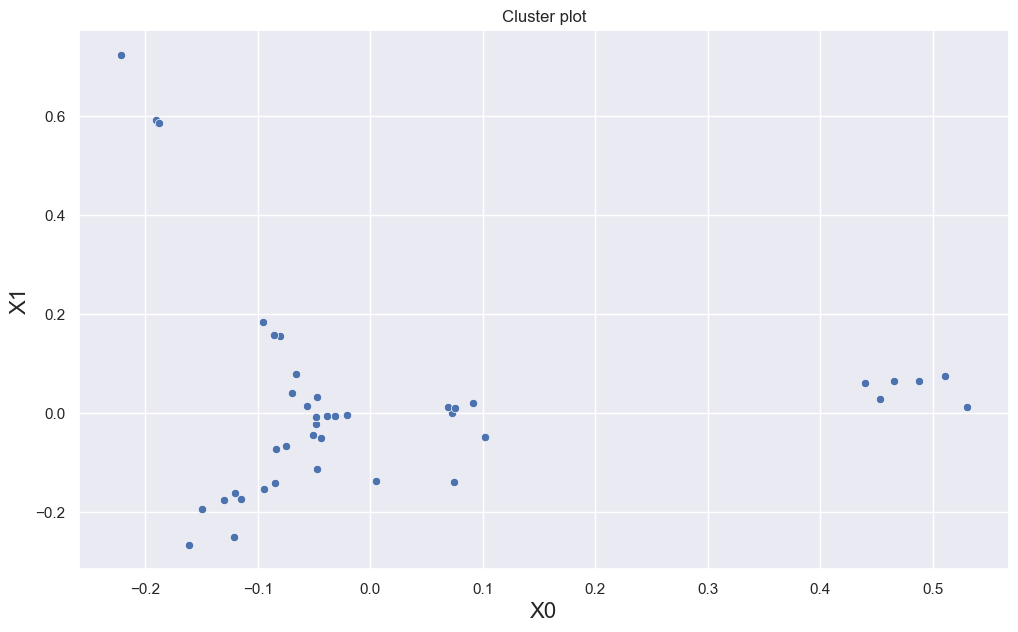

In [82]:
plt.figure(figsize=(12,7))
plt.title("Cluster plot")
plt.xlabel('X0', fontdict={'fontsize':16})
plt.ylabel('X1', fontdict={'fontsize':16})
sns.scatterplot(data=masterDF_plot, x = "x00", y = "x11");



# Plot using UMAP

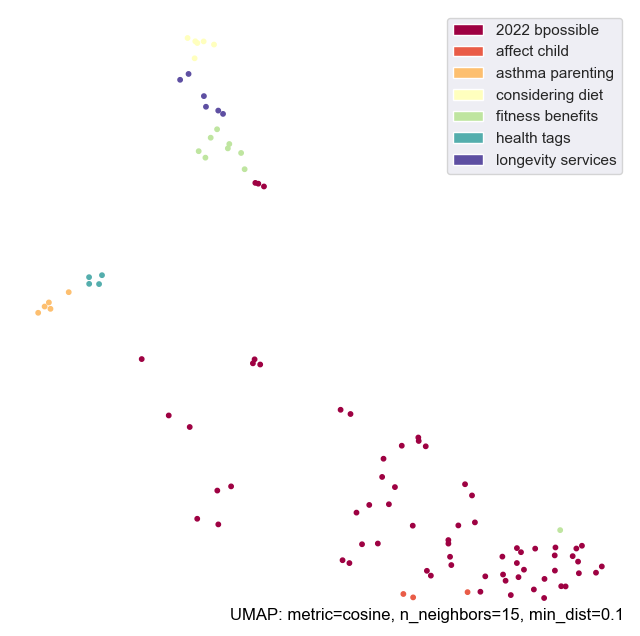

In [85]:
plot_frame = pd.DataFrame(masterDF_plot['Cluster'], columns=['Category'])
plot_frame['Category'] = masterDF_plot['Cluster']
embeddings = umap.UMAP(n_components = 2, metric = 'cosine').fit(TfidF_vect)
f = umap.plot.points(embeddings, labels=plot_frame['Category'])

# Check accuracy and loss

In [86]:
from sklearn.preprocessing import LabelEncoder


In [90]:
df_work = pd.DataFrame(masterDF_plot['Cluster'], columns=['Cluster'])
df_work['keyword_name'] = masterDF_plot['keyword_name']
df_work['encoded_category'] = LabelEncoder().fit_transform(df_work['Cluster'])
df_work

,Cluster,keyword_name,encoded_category
0,considering diet,paleo diet,3
1,longevity services,nutrition trending,6
2,2022 bpossible,best supplements,0
3,longevity services,nutrition chaga,6
4,2022 bpossible,documentaries access,0
...,...,...,...
95,2022 bpossible,prenatal vitamins,0
96,asthma parenting,parenting faqs,2
97,2022 bpossible,good prenatal,0
98,asthma parenting,habits parenting,2


**Create model**

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_work['keyword_name'], df_work['encoded_category'], test_size=0.2, stratify=df_work['Cluster'], random_state=42)


In [99]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [100]:
import scipy
import tensorflow as tf
X_train = scipy.sparse.csr_matrix.todense(X_train)
X_test = scipy.sparse.csr_matrix.todense(X_test)

In [103]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(df_work['Cluster'].nunique(), activation='softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
3/3 - 1s - loss: 1.9527 - accuracy: 0.0875 - val_loss: 1.9149 - val_accuracy: 0.3000 - 985ms/epoch - 328ms/step
Epoch 2/100
3/3 - 0s - loss: 1.9195 - accuracy: 0.1875 - val_loss: 1.8879 - val_accuracy: 0.5500 - 59ms/epoch - 20ms/step
Epoch 3/100
3/3 - 0s - loss: 1.8794 - accuracy: 0.3500 - val_loss: 1.8611 - val_accuracy: 0.7000 - 53ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 1.8315 - accuracy: 0.5625 - val_loss: 1.8339 - val_accuracy: 0.7000 - 54ms/epoch - 18ms/step
Epoch 5/100
3/3 - 0s - loss: 1.7959 - accuracy: 0.6250 - val_loss: 1.8045 - val_accuracy: 0.6500 - 63ms/epoch - 21ms/step
Epoch 6/100
3/3 - 0s - loss: 1.7600 - accuracy: 0.6750 - val_loss: 1.7737 - val_accuracy: 0.6500 - 59ms/epoch - 20ms/step
Epoch 7/100
3/3 - 0s - loss: 1.7128 - accuracy: 0.6750 - val_loss: 1.7404 - val_accuracy: 0.6500 - 59ms/epoch - 20ms/step
Epoch 8/100
3/3 - 0s - loss: 1.6856 - accuracy: 0.6875 - val_loss: 1.7048 - val_accuracy: 0.6500 - 74ms/epoch - 25ms/step
Epoch 9/100
3/3 - 0s -

Epoch 68/100
3/3 - 0s - loss: 0.1109 - accuracy: 1.0000 - val_loss: 0.2811 - val_accuracy: 0.9000 - 55ms/epoch - 18ms/step
Epoch 69/100
3/3 - 0s - loss: 0.1197 - accuracy: 1.0000 - val_loss: 0.2710 - val_accuracy: 0.9500 - 53ms/epoch - 18ms/step
Epoch 70/100
3/3 - 0s - loss: 0.1072 - accuracy: 1.0000 - val_loss: 0.2610 - val_accuracy: 0.9500 - 53ms/epoch - 18ms/step
Epoch 71/100
3/3 - 0s - loss: 0.1241 - accuracy: 0.9875 - val_loss: 0.2512 - val_accuracy: 0.9500 - 57ms/epoch - 19ms/step
Epoch 72/100
3/3 - 0s - loss: 0.1356 - accuracy: 0.9750 - val_loss: 0.2436 - val_accuracy: 0.9500 - 59ms/epoch - 20ms/step
Epoch 73/100
3/3 - 0s - loss: 0.1099 - accuracy: 0.9875 - val_loss: 0.2375 - val_accuracy: 0.9500 - 56ms/epoch - 19ms/step
Epoch 74/100
3/3 - 0s - loss: 0.0690 - accuracy: 1.0000 - val_loss: 0.2315 - val_accuracy: 0.9500 - 48ms/epoch - 16ms/step
Epoch 75/100
3/3 - 0s - loss: 0.0811 - accuracy: 1.0000 - val_loss: 0.2254 - val_accuracy: 0.9500 - 56ms/epoch - 19ms/step
Epoch 76/100
3/3

In [104]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               13824     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 7)                 231       
                                                                 
Total params: 18,183
Trainable params: 18,183
Non-trainable params: 0
_________________________________________________________________


# Visualization loss and accuracy

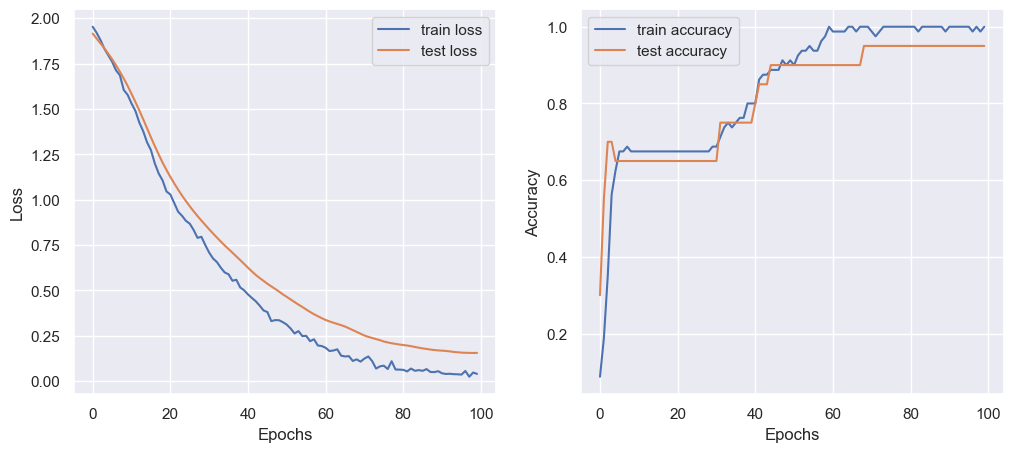

In [106]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'test loss'])
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']);
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train accuracy', 'test accuracy']);
